In [32]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
# from joblib import dump

from load_data import get_lidar, get_encoder, get_imu
from p3_util import replay_lidar


%matplotlib inline

### Load Training Data

In [11]:
dir_train_data = "./data/"
fnames = {'Encoders':[], 'Hokuyo': [], 'imu': []}
for name in np.array(os.listdir(dir_train_data)):
    for k in fnames.keys():
        if name.startswith(k):
            fnames[k].append(name.split(".")[0])
            continue
            
print(fnames)

{'Encoders': ['Encoders20', 'Encoders21', 'Encoders23'], 'Hokuyo': ['Hokuyo20', 'Hokuyo21', 'Hokuyo23'], 'imu': ['imu20', 'imu21', 'imu23']}


In [31]:
train_data = {}

def load_data(filename):
    fpath = os.path.join(dir_train_data, filename)
    if filename.startswith('Encoders'):
        return get_encoder(fpath)
    elif filename.startswith('Hokuyo'):
        return get_lidar(fpath)
    elif filename.startswith('imu'):
        return get_imu(fpath)
    else:
        print("Load data error:", filename)

for k, v in fnames.items():
    if k not in train_data:
        train_data[k] = {}

    for fname in v:
        train_data[k][fname] = load_data(fname)

for k in fnames.keys():
    print("-----------------", k, "-------------------")
    for key, val in train_data[k].items():
        print(key + ":", (len(val), len(val[0])))

----------------- Encoders -------------------
Encoders20: (5, 4956)
Encoders21: (5, 4789)
Encoders23: (5, 3809)
----------------- Hokuyo -------------------
Hokuyo20: (4962, 3)
Hokuyo21: (4785, 3)
Hokuyo23: (3803, 3)
----------------- imu -------------------
imu20: (7, 12187)
imu21: (7, 11730)
imu23: (7, 9416)


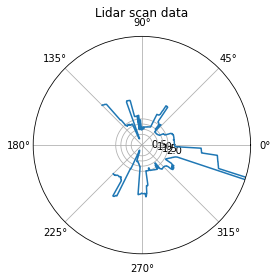

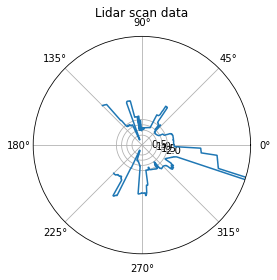

In [44]:
replay_lidar(train_data['Hokuyo']['Hokuyo20'][:220])